/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   8.43e-05      1.272      0.203    -5.8e-05       0.000
ar.L1.y       -0.1488      0.057     -2.622      0.009      -0.260      -0.038
ar.L2.y       -0.0578      0.057     -1.005      0.315      -0.170       0.055
ar.L3.y        0.0030      0.058      0.052      0.959      -0.110       0.116
ar.L4.y        0.0466      0.058      0.808      0.419      -0.067       0.160
ar.L5.y       -0.0352      0.058     -0.607      0.544      -0.149       0.078
ar.L6.y       -0.0331      0.058     -0.571      0.568      -0.147       0.081
ar.L7.y       -0.0360      0.057     -0.628      0.530      -0.148       0.076
ma.L1.y       -0.9999      0.010    -96.296      0.000      -1.020      -0.980


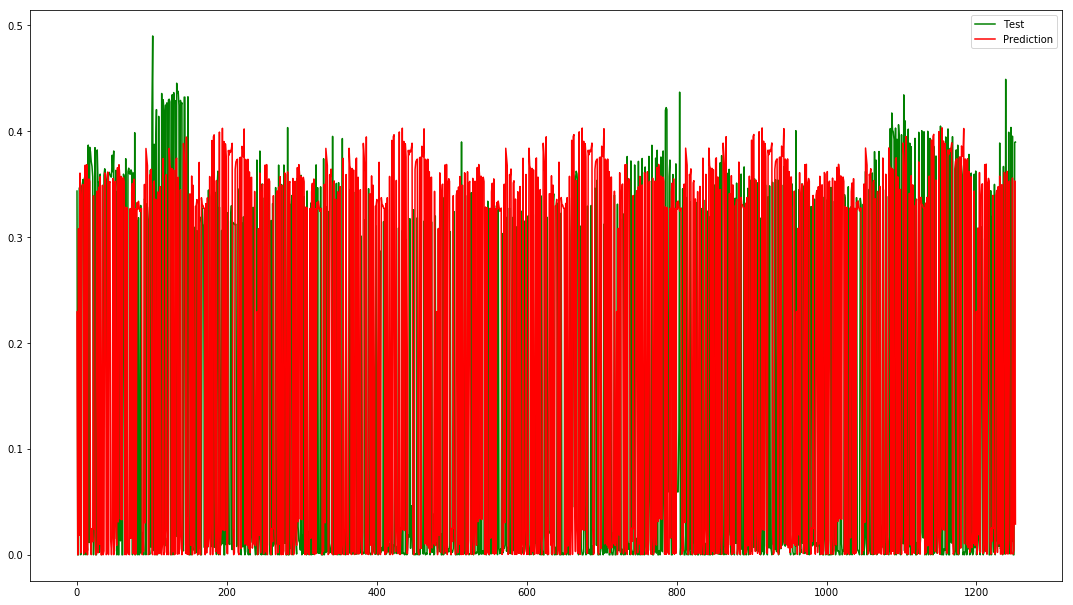

The Mean Squared Error of our forecasts is 0.06
['actual', 'prediction', 'actual_64', 'prediction_64', 'actual_128', 'prediction_128', 'actual_256', 'prediction_256', 'actual_512', 'prediction_512']


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import csv;

def isSeriesStationary(series):
    pValue = adfuller(series)[1]
    if pValue > 0.05:
        return False
    else:
        return True
    
def isSeriesStationaryAvg(series, delta = 2):
    split = int(len(series)/2)
    split1, split2 = series[:split], series[split:]
    avg1, avg2 = split1.mean(), split2.mean()
    var1, var2 = split1.var(), split2.var()
    if abs(avg1 - avg2) > delta or abs(var1 - var2) > delta**2:
        return False
    else:
        return True
    
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def describeSeries(data, label):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(data, label = "Series")
    plt.plot(pd.rolling_mean(data, window = 2), '--', label = "Rolling mean")
    plt.plot(pd.rolling_std(data, 2), ":", label = "Rolling Std")
    plt.legend()
    plt.clf()
    
def splitTrainTest(series, testSplit):
    totalData = len(series)
    trainSplit = int(totalData * (1 - testSplit))
    trainSet = series[:trainSplit]
    testSet = series[trainSplit:]
    return trainSet, testSet

temperatureData = pd.read_csv("/Users/hasan/workplace/hypervisor/spot-memory/cluster_trace/machine_usage_30905607.csv", dtype={'total mem': float})
temperatureData.head()


trainSet, testSet = splitTrainTest(temperatureData["max mem"].values, 0.8)

differencedTrainSet = difference(trainSet, 1)
model = ARIMA(differencedTrainSet, order=(7,0,1))
"""Fit model with non constant trend and no displacement"""
model_fit = model.fit(disp = 0)
forecast = model_fit.predict(len(differencedTrainSet), len(differencedTrainSet) + len(testSet))

print(model_fit.summary().tables[1])

yPrediction = []
history = list(trainSet)
for f in forecast:
    yPredict = inverse_difference(history, f, 240)
    yPrediction.append(yPredict)
    history.append(yPredict)
    

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(testSet, color='green', label = "Test")
plt.plot(yPrediction[:-1], color='red', label = "Prediction")
plt.legend()
plt.show()

yPrediction = yPrediction[:-1]

# Compute the mean square error
mse = ((yPrediction - testSet) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

fields = ["actual", "prediction"]
size = [64, 128, 256, 512]
for s in size:
    fields.append("actual_"+str(s))
    fields.append("prediction_"+str(s));

print(fields)
with open('./prediction.csv', mode='w') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fields);
        writer.writeheader();
        for idx in range(0, len(testSet)):
            row = {"actual":testSet[idx], "prediction": max (0,yPrediction[idx])}
            for s in size:
                row["actual_"+str(s)] = float(row["actual"] * (int) (s));
                row["prediction_"+str(s)] = float(row["prediction"] * (int) (s));
            writer.writerow(row);
